# GraphCL - Unsupervised 

# Layers

In [1]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, n_h):
        super(Discriminator, self).__init__()
        self.f_k = nn.Bilinear(n_h, n_h, 1)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Bilinear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, c, h_pl, h_mi, s_bias1=None, s_bias2=None):
        c_x = torch.unsqueeze(c, 1)
        c_x = c_x.expand_as(h_pl)

        sc_1 = torch.squeeze(self.f_k(h_pl, c_x), 2)
        sc_2 = torch.squeeze(self.f_k(h_mi, c_x), 2)

        if s_bias1 is not None:
            sc_1 += s_bias1
        if s_bias2 is not None:
            sc_2 += s_bias2

        logits = torch.cat((sc_1, sc_2), 1)

        return logits

class Discriminator2(nn.Module):
    def __init__(self, n_h):
        super(Discriminator2, self).__init__()
        self.f_k = nn.Bilinear(n_h, n_h, 1)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Bilinear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, c, h_pl, h_mi, s_bias1=None, s_bias2=None):
        # c_x = torch.unsqueeze(c, 1)
        # c_x = c_x.expand_as(h_pl)
        c_x = c
        sc_1 = torch.squeeze(self.f_k(h_pl, c_x), 2) #positive
        sc_2 = torch.squeeze(self.f_k(h_mi, c_x), 2) #negative

        if s_bias1 is not None:
            sc_1 += s_bias1
        if s_bias2 is not None:
            sc_2 += s_bias2

        logits = torch.cat((sc_1, sc_2), 1)

        return logits

class GCN(nn.Module):
    def __init__(self, in_ft, out_ft, act, bias=True):
        super(GCN, self).__init__()
        self.fc = nn.Linear(in_ft, out_ft, bias=False)
        self.act = nn.PReLU() if act == 'prelu' else act
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_ft))
            self.bias.data.fill_(0.0)
        else:
            self.register_parameter('bias', None)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    # Shape of seq: (batch, nodes, features)
    def forward(self, seq, adj, sparse=False):
        seq_fts = self.fc(seq)
        if sparse:
            out = torch.unsqueeze(torch.spmm(adj, torch.squeeze(seq_fts, 0)), 0)
        else:
            out = torch.bmm(adj, seq_fts)
        if self.bias is not None:
            out += self.bias
        
        return self.act(out)

# Applies an average on seq, of shape (batch, nodes, features)
# While taking into account the masking of msk
class AvgReadout(nn.Module):
    def __init__(self):
        super(AvgReadout, self).__init__()

    def forward(self, seq, msk):
        if msk is None:
            return torch.mean(seq, 1)
        else:
            msk = torch.unsqueeze(msk, -1)
            return torch.sum(seq * msk, 1) / torch.sum(msk)

# Models

In [2]:
import torch
import torch.nn as nn
#from layers import GCN, AvgReadout, Discriminator, Discriminator2
import pdb

class DGI(nn.Module):
    def __init__(self, n_in, n_h, activation):
        super(DGI, self).__init__()
        self.gcn = GCN(n_in, n_h, activation)
        self.read = AvgReadout()
        self.sigm = nn.Sigmoid()
        self.disc = Discriminator(n_h)
        self.disc2 = Discriminator2(n_h)

    def forward(self, seq1, seq2, seq3, seq4, adj, aug_adj1, aug_adj2, sparse, msk, samp_bias1, samp_bias2, aug_type):
        
        h_0 = self.gcn(seq1, adj, sparse) #positive sample
        if aug_type == 'edge':

            h_1 = self.gcn(seq1, aug_adj1, sparse)
            h_3 = self.gcn(seq1, aug_adj2, sparse)

        elif aug_type == 'mask':

            h_1 = self.gcn(seq3, adj, sparse)
            h_3 = self.gcn(seq4, adj, sparse)

        elif aug_type == 'node' or aug_type == 'subgraph':

            h_1 = self.gcn(seq3, aug_adj1, sparse)
            h_3 = self.gcn(seq4, aug_adj2, sparse)
            
        else:
            assert False
            
        c_1 = self.read(h_1, msk)
        c_1= self.sigm(c_1)

        c_3 = self.read(h_3, msk)
        c_3= self.sigm(c_3)

        h_2 = self.gcn(seq2, adj, sparse) #negative sample

        ret1 = self.disc(c_1, h_0, h_2, samp_bias1, samp_bias2) #logit (x1, x2)   #positive sample logit -> 1
        ret2 = self.disc(c_3, h_0, h_2, samp_bias1, samp_bias2) #logit (x1', x2') #negative sample logit -> 0

        ret = ret1 + ret2
        return ret

    # Detach the return variables
    def embed(self, seq, adj, sparse, msk):
        h_1 = self.gcn(seq, adj, sparse)
        c = self.read(h_1, msk)

        return h_1.detach(), c.detach()

import torch
import torch.nn as nn
import torch.nn.functional as F


class LogReg(nn.Module):
    def __init__(self, ft_in, nb_classes):
        super(LogReg, self).__init__()
        self.fc = nn.Linear(ft_in, nb_classes)

        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, seq):
        ret = self.fc(seq)
        return ret

# Utils

In [3]:
import numpy as np
import pickle as pkl
import networkx as nx
import scipy.sparse as sp
import sys
import torch
import torch.nn as nn

class process():
    def parse_skipgram(fname):
        with open(fname) as f:
            toks = list(f.read().split())
        nb_nodes = int(toks[0])
        nb_features = int(toks[1])
        ret = np.empty((nb_nodes, nb_features))
        it = 2
        for i in range(nb_nodes):
            cur_nd = int(toks[it]) - 1
            it += 1
            for j in range(nb_features):
                cur_ft = float(toks[it])
                ret[cur_nd][j] = cur_ft
                it += 1
        return ret

    # Process a (subset of) a TU dataset into standard form
    def process_tu(data, nb_nodes):
        nb_graphs = len(data)
        ft_size = data.num_features

        features = np.zeros((nb_graphs, nb_nodes, ft_size))
        adjacency = np.zeros((nb_graphs, nb_nodes, nb_nodes))
        labels = np.zeros(nb_graphs)
        sizes = np.zeros(nb_graphs, dtype=np.int32)
        masks = np.zeros((nb_graphs, nb_nodes))
        
        for g in range(nb_graphs):
            sizes[g] = data[g].x.shape[0]
            features[g, :sizes[g]] = data[g].x
            labels[g] = data[g].y[0]
            masks[g, :sizes[g]] = 1.0
            e_ind = data[g].edge_index
            coo = sp.coo_matrix((np.ones(e_ind.shape[1]), (e_ind[0, :], e_ind[1, :])), shape=(nb_nodes, nb_nodes))
            adjacency[g] = coo.todense()

        return features, adjacency, labels, sizes, masks

    def micro_f1(logits, labels):
        # Compute predictions
        preds = torch.round(nn.Sigmoid()(logits))
        
        # Cast to avoid trouble
        preds = preds.long()
        labels = labels.long()

        # Count true positives, true negatives, false positives, false negatives
        tp = torch.nonzero(preds * labels).shape[0] * 1.0
        tn = torch.nonzero((preds - 1) * (labels - 1)).shape[0] * 1.0
        fp = torch.nonzero(preds * (labels - 1)).shape[0] * 1.0
        fn = torch.nonzero((preds - 1) * labels).shape[0] * 1.0

        # Compute micro-f1 score
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
        f1 = (2 * prec * rec) / (prec + rec)
        return f1

    """
    Prepare adjacency matrix by expanding up to a given neighbourhood.
    This will insert loops on every node.
    Finally, the matrix is converted to bias vectors.
    Expected shape: [graph, nodes, nodes]
    """
    def adj_to_bias(adj, sizes, nhood=1):
        nb_graphs = adj.shape[0]
        mt = np.empty(adj.shape)
        for g in range(nb_graphs):
            mt[g] = np.eye(adj.shape[1])
            for _ in range(nhood):
                mt[g] = np.matmul(mt[g], (adj[g] + np.eye(adj.shape[1])))
            for i in range(sizes[g]):
                for j in range(sizes[g]):
                    if mt[g][i][j] > 0.0:
                        mt[g][i][j] = 1.0
        return -1e9 * (1.0 - mt)


    ###############################################
    # This section of code adapted from tkipf/gcn #
    ###############################################

    def parse_index_file(filename):
        """Parse index file."""
        index = []
        for line in open(filename):
            index.append(int(line.strip()))
        return index

    def sample_mask(idx, l):
        """Create mask."""
        mask = np.zeros(l)
        mask[idx] = 1
        return np.array(mask, dtype=np.bool)

    def load_data(dataset_str): # {'pubmed', 'citeseer', 'cora'}
        """Load data."""
        names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
        objects = []
        for i in range(len(names)):
            with open("/content/data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
                if sys.version_info > (3, 0):
                    objects.append(pkl.load(f, encoding='latin1'))
                else:
                    objects.append(pkl.load(f))

        x, y, tx, ty, allx, ally, graph = tuple(objects)
        test_idx_reorder = process.parse_index_file("/content/data/ind.{}.test.index.txt".format(dataset_str))
        test_idx_range = np.sort(test_idx_reorder)

        if dataset_str == 'citeseer':
            # Fix citeseer dataset (there are some isolated nodes in the graph)
            # Find isolated nodes, add them as zero-vecs into the right position
            test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
            tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
            tx_extended[test_idx_range-min(test_idx_range), :] = tx
            tx = tx_extended
            ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
            ty_extended[test_idx_range-min(test_idx_range), :] = ty
            ty = ty_extended

        features = sp.vstack((allx, tx)).tolil()
        features[test_idx_reorder, :] = features[test_idx_range, :]
        adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

        labels = np.vstack((ally, ty))
        labels[test_idx_reorder, :] = labels[test_idx_range, :]

        idx_test = test_idx_range.tolist()
        idx_train = range(len(y))
        idx_val = range(len(y), len(y)+500)

        return adj, features, labels, idx_train, idx_val, idx_test

    def sparse_to_tuple(sparse_mx, insert_batch=False):
        """Convert sparse matrix to tuple representation."""
        """Set insert_batch=True if you want to insert a batch dimension."""
        def to_tuple(mx):
            if not sp.isspmatrix_coo(mx):
                mx = mx.tocoo()
            if insert_batch:
                coords = np.vstack((np.zeros(mx.row.shape[0]), mx.row, mx.col)).transpose()
                values = mx.data
                shape = (1,) + mx.shape
            else:
                coords = np.vstack((mx.row, mx.col)).transpose()
                values = mx.data
                shape = mx.shape
            return coords, values, shape

        if isinstance(sparse_mx, list):
            for i in range(len(sparse_mx)):
                sparse_mx[i] = to_tuple(sparse_mx[i])
        else:
            sparse_mx = to_tuple(sparse_mx)

        return sparse_mx

    def standardize_data(f, train_mask):
        """Standardize feature matrix and convert to tuple representation"""
        # standardize data
        f = f.todense()
        mu = f[train_mask == True, :].mean(axis=0)
        sigma = f[train_mask == True, :].std(axis=0)
        f = f[:, np.squeeze(np.array(sigma > 0))]
        mu = f[train_mask == True, :].mean(axis=0)
        sigma = f[train_mask == True, :].std(axis=0)
        f = (f - mu) / sigma
        return f

    def preprocess_features(features):
        """Row-normalize feature matrix and convert to tuple representation"""
        rowsum = np.array(features.sum(1))
        r_inv = np.power(rowsum, -1).flatten()
        r_inv[np.isinf(r_inv)] = 0.
        r_mat_inv = sp.diags(r_inv)
        features = r_mat_inv.dot(features)
        return features.todense(), process.sparse_to_tuple(features)

    def normalize_adj(adj):
        """Symmetrically normalize adjacency matrix."""
        adj = sp.coo_matrix(adj)
        rowsum = np.array(adj.sum(1))
        d_inv_sqrt = np.power(rowsum, -0.5).flatten()
        d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
        d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
        return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()


    def preprocess_adj(adj):
        """Preprocessing of adjacency matrix for simple GCN model and conversion to tuple representation."""
        adj_normalized = process.normalize_adj(adj + sp.eye(adj.shape[0]))
        return process.sparse_to_tuple(adj_normalized)

    def sparse_mx_to_torch_sparse_tensor(sparse_mx):
        """Convert a scipy sparse matrix to a torch sparse tensor."""
        sparse_mx = sparse_mx.tocoo().astype(np.float32)
        indices = torch.from_numpy(
            np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
        values = torch.from_numpy(sparse_mx.data)
        shape = torch.Size(sparse_mx.shape)
        return torch.sparse.FloatTensor(indices, values, shape)

# Augmentation

In [4]:
import torch
import copy
import random
import pdb
import scipy.sparse as sp
import numpy as np

def main():
    pass


def aug_random_mask(input_feature, drop_percent=0.2):
    
    node_num = input_feature.shape[1]
    mask_num = int(node_num * drop_percent)
    node_idx = [i for i in range(node_num)]
    mask_idx = random.sample(node_idx, mask_num)
    aug_feature = copy.deepcopy(input_feature)
    zeros = torch.zeros_like(aug_feature[0][0])
    for j in mask_idx:
        aug_feature[0][j] = zeros
    return aug_feature


def aug_random_edge(input_adj, drop_percent=0.2):

    percent = drop_percent / 2
    row_idx, col_idx = input_adj.nonzero()

    index_list = []
    for i in range(len(row_idx)):
        index_list.append((row_idx[i], col_idx[i]))

    single_index_list = []
    for i in list(index_list):
        single_index_list.append(i)
        index_list.remove((i[1], i[0]))
    
    
    edge_num = int(len(row_idx) / 2)      # 9228 / 2
    add_drop_num = int(edge_num * percent / 2) 
    aug_adj = copy.deepcopy(input_adj.todense().tolist())

    edge_idx = [i for i in range(edge_num)]
    drop_idx = random.sample(edge_idx, add_drop_num)

    
    for i in drop_idx:
        aug_adj[single_index_list[i][0]][single_index_list[i][1]] = 0
        aug_adj[single_index_list[i][1]][single_index_list[i][0]] = 0
    
    '''
    above finish drop edges
    '''
    node_num = input_adj.shape[0]
    l = [(i, j) for i in range(node_num) for j in range(i)]
    add_list = random.sample(l, add_drop_num)

    for i in add_list:
        
        aug_adj[i[0]][i[1]] = 1
        aug_adj[i[1]][i[0]] = 1
    
    aug_adj = np.matrix(aug_adj)
    aug_adj = sp.csr_matrix(aug_adj)
    return aug_adj


def aug_drop_node(input_fea, input_adj, drop_percent=0.2):

    input_adj = torch.tensor(input_adj.todense().tolist())
    input_fea = input_fea.squeeze(0)

    node_num = input_fea.shape[0]
    drop_num = int(node_num * drop_percent)    # number of drop nodes
    all_node_list = [i for i in range(node_num)]

    drop_node_list = sorted(random.sample(all_node_list, drop_num))

    aug_input_fea = delete_row_col(input_fea, drop_node_list, only_row=True)
    aug_input_adj = delete_row_col(input_adj, drop_node_list)

    aug_input_fea = aug_input_fea.unsqueeze(0)
    aug_input_adj = sp.csr_matrix(np.matrix(aug_input_adj))

    return aug_input_fea, aug_input_adj


def aug_subgraph(input_fea, input_adj, drop_percent=0.2):
    
    input_adj = torch.tensor(input_adj.todense().tolist())
    input_fea = input_fea.squeeze(0)
    node_num = input_fea.shape[0]

    all_node_list = [i for i in range(node_num)]
    s_node_num = int(node_num * (1 - drop_percent))
    center_node_id = random.randint(0, node_num - 1)
    sub_node_id_list = [center_node_id]
    all_neighbor_list = []

    for i in range(s_node_num - 1):
        
        all_neighbor_list += torch.nonzero(input_adj[sub_node_id_list[i]], as_tuple=False).squeeze(1).tolist()
        
        all_neighbor_list = list(set(all_neighbor_list))
        new_neighbor_list = [n for n in all_neighbor_list if not n in sub_node_id_list]
        if len(new_neighbor_list) != 0:
            new_node = random.sample(new_neighbor_list, 1)[0]
            sub_node_id_list.append(new_node)
        else:
            break

    
    drop_node_list = sorted([i for i in all_node_list if not i in sub_node_id_list])

    aug_input_fea = delete_row_col(input_fea, drop_node_list, only_row=True)
    aug_input_adj = delete_row_col(input_adj, drop_node_list)

    aug_input_fea = aug_input_fea.unsqueeze(0)
    aug_input_adj = sp.csr_matrix(np.matrix(aug_input_adj))

    return aug_input_fea, aug_input_adj





def delete_row_col(input_matrix, drop_list, only_row=False):

    remain_list = [i for i in range(input_matrix.shape[0]) if i not in drop_list]
    out = input_matrix[remain_list, :]
    if only_row:
        return out
    out = out[:, remain_list]

    return out

if __name__ == "__main__":
    main()

# Execute

In [5]:
import argparse
import os

parser = argparse.ArgumentParser("My DGI")

parser.add_argument('--dataset',          type=str,           default="cora",                help='data')
parser.add_argument('--aug_type',         type=str,           default="node",                help='aug type: mask or edge')
parser.add_argument('--drop_percent',     type=float,         default=0.1,               help='drop percent')
parser.add_argument('--seed',             type=int,           default=39,                help='seed')
parser.add_argument('--gpu',              type=int,           default=0,                 help='gpu')
parser.add_argument('--save_name',        type=str,           default='try.pkl_cora_node',                help='save ckpt name')

args, unknown = parser.parse_known_args() ##

print('-' * 100)
print(args)
print('-' * 100)

----------------------------------------------------------------------------------------------------
Namespace(dataset='cora', aug_type='node', drop_percent=0.1, seed=39, gpu=0, save_name='try.pkl_cora_node')
----------------------------------------------------------------------------------------------------


In [6]:
dataset = args.dataset
aug_type = args.aug_type
drop_percent = args.drop_percent
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu) 
seed = args.seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [7]:
# training params

batch_size = 1
nb_epochs = 10000
patience = 20
lr = 0.001
l2_coef = 0.0
drop_prob = 0.0
hid_units = 512
sparse = True


nonlinearity = 'prelu' # special name to separate parameters

adj, features, labels, idx_train, idx_val, idx_test = process.load_data(dataset)
features, _ = process.preprocess_features(features)

nb_nodes = features.shape[0]  # node number
ft_size = features.shape[1]   # node features dim
nb_classes = labels.shape[1]  # classes = 6

features = torch.FloatTensor(features[np.newaxis])


'''
------------------------------------------------------------
edge node mask subgraph
------------------------------------------------------------
'''
print("Begin Aug:[{}]".format(args.aug_type))
if args.aug_type == 'edge':

    aug_features1 = features
    aug_features2 = features

    aug_adj1 = aug_random_edge(adj, drop_percent=drop_percent) # random drop edges
    aug_adj2 = aug_random_edge(adj, drop_percent=drop_percent) # random drop edges
    
elif args.aug_type == 'node':
    
    aug_features1, aug_adj1 = aug_drop_node(features, adj, drop_percent=drop_percent)
    aug_features2, aug_adj2 = aug_drop_node(features, adj, drop_percent=drop_percent)
    
elif args.aug_type == 'subgraph':
    
    aug_features1, aug_adj1 = aug_subgraph(features, adj, drop_percent=drop_percent)
    aug_features2, aug_adj2 = aug_subgraph(features, adj, drop_percent=drop_percent)

elif args.aug_type == 'mask':

    aug_features1 = aug_random_mask(features,  drop_percent=drop_percent)
    aug_features2 = aug_random_mask(features,  drop_percent=drop_percent)
    
    aug_adj1 = adj
    aug_adj2 = adj

else:
    assert False



'''
------------------------------------------------------------
'''

adj = process.normalize_adj(adj + sp.eye(adj.shape[0]))
aug_adj1 = process.normalize_adj(aug_adj1 + sp.eye(aug_adj1.shape[0]))
aug_adj2 = process.normalize_adj(aug_adj2 + sp.eye(aug_adj2.shape[0]))

if sparse:
    sp_adj = process.sparse_mx_to_torch_sparse_tensor(adj)
    sp_aug_adj1 = process.sparse_mx_to_torch_sparse_tensor(aug_adj1)
    sp_aug_adj2 = process.sparse_mx_to_torch_sparse_tensor(aug_adj2)

else:
    adj = (adj + sp.eye(adj.shape[0])).todense()
    aug_adj1 = (aug_adj1 + sp.eye(aug_adj1.shape[0])).todense()
    aug_adj2 = (aug_adj2 + sp.eye(aug_adj2.shape[0])).todense()


'''
------------------------------------------------------------
mask
------------------------------------------------------------
'''

'''
------------------------------------------------------------
'''
if not sparse:
    adj = torch.FloatTensor(adj[np.newaxis])
    aug_adj1 = torch.FloatTensor(aug_adj1[np.newaxis])
    aug_adj2 = torch.FloatTensor(aug_adj2[np.newaxis])


labels = torch.FloatTensor(labels[np.newaxis])
idx_train = torch.LongTensor(idx_train)
idx_val = torch.LongTensor(idx_val)
idx_test = torch.LongTensor(idx_test)

model = DGI(ft_size, hid_units, nonlinearity)
optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_coef)

if torch.cuda.is_available():
    print('Using CUDA')
    model.cuda()
    features = features.cuda()
    aug_features1 = aug_features1.cuda()
    aug_features2 = aug_features2.cuda()
    if sparse:
        sp_adj = sp_adj.cuda()
        sp_aug_adj1 = sp_aug_adj1.cuda()
        sp_aug_adj2 = sp_aug_adj2.cuda()
    else:
        adj = adj.cuda()
        aug_adj1 = aug_adj1.cuda()
        aug_adj2 = aug_adj2.cuda()

    labels = labels.cuda()
    idx_train = idx_train.cuda()
    idx_val = idx_val.cuda()
    idx_test = idx_test.cuda()

b_xent = nn.BCEWithLogitsLoss()
xent = nn.CrossEntropyLoss()
cnt_wait = 0
best = 1e9
best_t = 0

loss_list=[]
for epoch in range(nb_epochs):

    model.train()
    optimiser.zero_grad()

    idx = np.random.permutation(nb_nodes) #negative sampling
    shuf_fts = features[:, idx, :] #negative sampling

    lbl_1 = torch.ones(batch_size, nb_nodes)
    lbl_2 = torch.zeros(batch_size, nb_nodes)
    lbl = torch.cat((lbl_1, lbl_2), 1)

    if torch.cuda.is_available():
        shuf_fts = shuf_fts.cuda()
        lbl = lbl.cuda()
    
    logits = model(features, shuf_fts, aug_features1, aug_features2,
                   sp_adj if sparse else adj, 
                   sp_aug_adj1 if sparse else aug_adj1,
                   sp_aug_adj2 if sparse else aug_adj2,  
                   sparse, None, None, None, aug_type=aug_type) 

    loss = b_xent(logits, lbl)
    loss_list.append(loss.item())
    print('Loss:[{:.4f}]'.format(loss.item()))

    if loss < best:
        best = loss
        best_t = epoch
        cnt_wait = 0
        torch.save(model.state_dict(), args.save_name)
    else:
        cnt_wait += 1

    if cnt_wait == patience:
        print('Early stopping!')
        break

    loss.backward()
    optimiser.step()

print('Loading {}th epoch'.format(best_t))
model.load_state_dict(torch.load(args.save_name))

embeds, _ = model.embed(features, sp_adj if sparse else adj, sparse, None)
train_embs = embeds[0, idx_train]
val_embs = embeds[0, idx_val]
test_embs = embeds[0, idx_test]

train_lbls = torch.argmax(labels[0, idx_train], dim=1)
val_lbls = torch.argmax(labels[0, idx_val], dim=1)
test_lbls = torch.argmax(labels[0, idx_test], dim=1)

tot = torch.zeros(1)
tot = tot.cuda()

accs = []

acc_list=[]
for _ in range(50):
    log = LogReg(hid_units, nb_classes)
    opt = torch.optim.Adam(log.parameters(), lr=0.01, weight_decay=0.0)
    log.cuda()

    pat_steps = 0
    best_acc = torch.zeros(1)
    best_acc = best_acc.cuda()
    for _ in range(100):
        log.train()
        opt.zero_grad()

        logits = log(train_embs)
        loss = xent(logits, train_lbls)
        
        loss.backward()
        opt.step()

    logits = log(test_embs)
    preds = torch.argmax(logits, dim=1)
    acc = torch.sum(preds == test_lbls).float() / test_lbls.shape[0]
    accs.append(acc * 100)
    print('acc:[{:.4f}]'.format(acc))
    acc_list.append(acc.item())
    tot += acc
    

print('-' * 100)
print('Average accuracy:[{:.4f}]'.format(tot.item() / 50))
accs = torch.stack(accs)
print('Mean:[{:.4f}]'.format(accs.mean().item()))
print('Std :[{:.4f}]'.format(accs.std().item()))
print('-' * 100)

<ipython-input-3-f553499646f4>:112: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  objects.append(pkl.load(f, encoding='latin1'))


Begin Aug:[node]
Using CUDA
Loss:[0.6931]
Loss:[0.7000]
Loss:[0.6857]
Loss:[0.6900]
Loss:[0.6860]
Loss:[0.6778]
Loss:[0.6742]
Loss:[0.6731]
Loss:[0.6628]
Loss:[0.6573]
Loss:[0.6523]
Loss:[0.6374]
Loss:[0.6347]
Loss:[0.6209]
Loss:[0.6094]
Loss:[0.6003]
Loss:[0.5825]
Loss:[0.5729]
Loss:[0.5558]
Loss:[0.5440]
Loss:[0.5242]
Loss:[0.5138]
Loss:[0.4968]
Loss:[0.4833]
Loss:[0.4683]
Loss:[0.4550]
Loss:[0.4401]
Loss:[0.4254]
Loss:[0.4147]
Loss:[0.3960]
Loss:[0.3821]
Loss:[0.3716]
Loss:[0.3574]
Loss:[0.3418]
Loss:[0.3274]
Loss:[0.3205]
Loss:[0.3176]
Loss:[0.3066]
Loss:[0.2939]
Loss:[0.2802]
Loss:[0.2854]
Loss:[0.2707]
Loss:[0.2679]
Loss:[0.2574]
Loss:[0.2560]
Loss:[0.2443]
Loss:[0.2257]
Loss:[0.2336]
Loss:[0.2214]
Loss:[0.2224]
Loss:[0.2120]
Loss:[0.2114]
Loss:[0.2075]
Loss:[0.2046]
Loss:[0.1923]
Loss:[0.2000]
Loss:[0.1907]
Loss:[0.1789]
Loss:[0.1820]
Loss:[0.1636]
Loss:[0.1696]
Loss:[0.1911]
Loss:[0.1744]
Loss:[0.1578]
Loss:[0.1571]
Loss:[0.1497]
Loss:[0.1561]
Loss:[0.1463]
Loss:[0.1444]
Loss:[

In [8]:
lbl

tensor([[1., 1., 1.,  ..., 0., 0., 0.]], device='cuda:0')

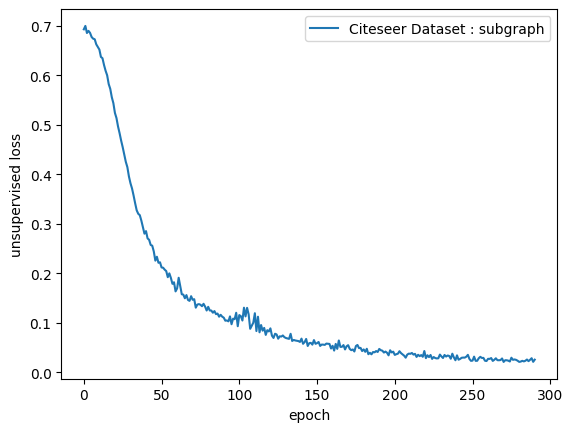

In [9]:
# plot the loss and accuracy
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.legend(['Citeseer Dataset : subgraph'])
plt.xlabel('epoch')
plt.ylabel('unsupervised loss')
plt.show()

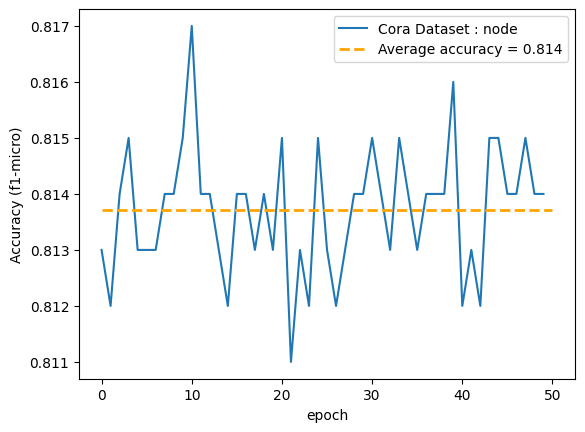

In [10]:
# plot the loss and accuracy
import matplotlib.pyplot as plt
plt.plot(acc_list)
avg_acc = accs.mean().item()/100
plt.hlines(accs.mean().item()/100, 0, 50, color='orange', linestyle='--', linewidth=2)
plt.legend(['Cora Dataset : node', f'Average accuracy = {np.round(avg_acc, 3)}'])
plt.xlabel('epoch')
plt.ylabel('Accuracy (f1-micro)')
plt.show()

In [11]:
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 51.2 MB/s eta 0:00:00


In [12]:
import dgl
from dgl import DGLGraph


from dgl.data import CitationGraphDataset
from dgl.data import CoraGraphDataset

Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.


In [13]:
citeseer = CitationGraphDataset('citeseer')

Extracting file to /root/.dgl/citeseer_d6836239


/usr/local/lib/python3.10/dist-packages/dgl/data/citation_graph.py:314: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


Finished data loading and preprocessing.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [14]:
cora = CoraGraphDataset('cora')

Extracting file to cora/cora_v2_d697a464
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.
